In [ ]:
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import stan
import arviz as az

In [ ]:
def local_level(num_timesteps=60, init_mu=10, 
                s_obs = 2, s_level=1,
                seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_level * mu_err[t]
        y[t] = mu[t] + s_obs * obs_err[t]

    return mu, y

In [ ]:
N = 100
s_obs = 2
s_level = 1

mu, y = local_level(num_timesteps=N, s_obs=s_obs, s_level=s_level, seeded=True, seed=5)

In [37]:
np.std(mu), np.std(y)

(3.8289410135665753, 4.378761274688515)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(y, label='emissions', color='k', alpha=.6)
ax.plot(mu, label = 'level', color='darkorange')
fig.legend()

In [38]:
level_code = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}
parameters {
  vector[N] mu_err;       // level innovation
  vector[N] obs_err;       // level innovation
  real<lower=0> s_level;
  real<lower=0> s_obs;
}
transformed parameters {
  vector[N] mu;           // level 
  mu[1] = mu_err[1];

  for (t in 2:N) {
    mu[t] = mu[t-1] + s_level * mu_err[t];
  }
}
model {
  mu_err ~ normal(0,1);
  obs_err ~ normal(0,1);
  s_obs ~ normal(0, 1);
  s_level ~ normal(0, 1);

  y ~ normal(mu, s_obs);
}
generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = mu[t] + s_obs * obs_err[t];
  }

}
"""

In [39]:
level_data = {"N": N,
                "y": y,}
level_data

{'N': 100,
 'y': array([11.58484523, 10.78275639,  6.60287561, 13.80172148, 13.28569482,
        14.43492145, 12.28819012, 18.11351021, 10.01548606, 14.12176804,
        12.429902  , 10.17096165, 12.57261516, 10.01866124,  6.51374945,
         7.18564766,  9.73534166, 14.44734775,  8.86622914, 10.28367735,
        13.86388258, 11.19554824,  8.37371276,  5.40922617,  4.26826474,
         7.33119559,  8.80260938,  5.10033642,  5.84791172,  9.84584758,
         8.31463553,  8.41601234,  8.47906356,  7.66265746, 11.04187179,
        12.41443935, 13.53097994, 11.00100469, 12.41056273, 13.7555729 ,
        15.86781186, 15.01547098, 14.0318966 , 10.43876298,  8.86410945,
        14.08742449, 13.43741735, 14.65308315, 13.48002415, 12.32062646,
        17.62624826, 17.16551502, 14.32650192, 15.92663524, 15.06742914,
        14.92241454, 19.49746196, 14.85435214, 14.62461675, 17.91356787,
        16.67257624, 18.62672117, 18.92284972, 18.95405716, 16.30282787,
        18.83242054, 16.99730913, 2

In [40]:
%%capture
model = stan.build(level_code, data=level_data, random_seed=1);
posterior = model.sample(num_chains=4, num_samples=1000)

In file included from /Users/woejozney/Library/Caches/httpstan/4.9.1/models/ndti67lj/model_ndti67lj.cpp:2:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from 

In [42]:
fitsum = az.summary(posterior)
fitsum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_err[0],3.508,0.915,1.755,5.211,0.016,0.011,3471.0,2668.0,1.0
mu_err[1],2.361,0.752,0.847,3.667,0.012,0.009,4130.0,2801.0,1.0
mu_err[2],1.185,0.848,-0.390,2.791,0.015,0.012,3097.0,2822.0,1.0
mu_err[3],1.783,0.833,0.332,3.449,0.012,0.009,5197.0,2995.0,1.0
mu_err[4],0.901,0.850,-0.639,2.546,0.012,0.010,4752.0,3170.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[95],19.352,2.493,14.744,24.123,0.034,0.024,5425.0,3198.0,1.0
y_hat[96],19.257,2.542,14.502,24.002,0.036,0.026,4964.0,2553.0,1.0
y_hat[97],19.120,2.547,14.447,23.969,0.038,0.027,4532.0,3109.0,1.0
y_hat[98],19.490,2.579,14.499,24.280,0.034,0.024,5774.0,2995.0,1.0


In [43]:
fitsum.loc['s_obs'], fitsum.loc['s_level']

(mean            2.180
 sd              0.220
 hdi_3%          1.776
 hdi_97%         2.588
 mcse_mean       0.005
 mcse_sd         0.003
 ess_bulk     2009.000
 ess_tail     3033.000
 r_hat           1.000
 Name: s_obs, dtype: float64,
 mean            1.402
 sd              0.231
 hdi_3%          0.990
 hdi_97%         1.859
 mcse_mean       0.006
 mcse_sd         0.004
 ess_bulk     1410.000
 ess_tail     2327.000
 r_hat           1.000
 Name: s_level, dtype: float64)

In [36]:
fitsum.loc['s_obs'], fitsum.loc['s_level']

(mean            2.179
 sd              0.219
 hdi_3%          1.788
 hdi_97%         2.591
 mcse_mean       0.005
 mcse_sd         0.004
 ess_bulk     1770.000
 ess_tail     2399.000
 r_hat           1.000
 Name: s_obs, dtype: float64,
 mean            1.415
 sd              0.243
 hdi_3%          0.953
 hdi_97%         1.855
 mcse_mean       0.007
 mcse_sd         0.005
 ess_bulk     1286.000
 ess_tail     2177.000
 r_hat           1.000
 Name: s_level, dtype: float64)

In [23]:
idata = az.from_pystan(posterior=posterior, posterior_predictive=["y_hat"], posterior_model=model, observed_data=['y'])
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/woejozney/opt/miniconda3/envs/timeseries/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


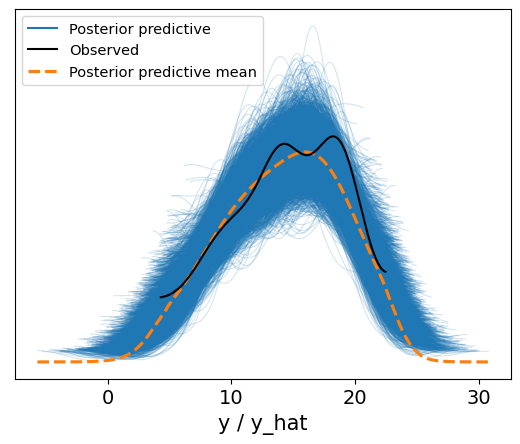

In [29]:
ax = az.plot_ppc(idata, data_pairs={'y': "y_hat"})


In [ ]:
ax.show()

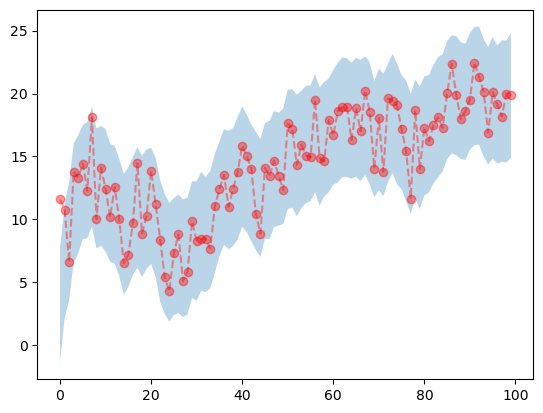

In [22]:
plt.fill_between(
    range(0,100),
    fitsum['y_hat[0]':'y_hat[99]']['hdi_97%'].values,
    fitsum['y_hat[0]':'y_hat[99]']['hdi_3%'].values,
    alpha=.3
    )
plt.plot(y, linestyle="--", marker="o", alpha=.4, color='r')
#plt.plot(fitsum['mu[0]':'mu[98]']['mean'].values, color='b', linestyle="--")
